# Inventory Monitoring at Distribution Centers

In distribution centres, robots are often used to move objects as part of their operations. Bins size and the number of objects in each bin differs, thus delivery of correct consignments can be challenging. To complete the task efficiently, machine leaning could be utilized to predict the number of items in each bin. 


In [2]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [95]:
#!pip install smdebug
#!pip install torch

In [5]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

#debugging plots
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

#deployment
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#read image
from PIL import Image
import io

[2023-01-27 21:45:28.695 datascience-1-0-ml-t3-medium-9edbb10f5bd76de5898a8f11f8e3:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [9]:
import os
import json
import boto3
from tqdm import tqdm


def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))


#download_and_arrange_data()

## Dataset
The publicly available Amazon Bin Image Dataset will be used in this project. This dataset contains over 500,000 images, where each image contains one or more projects. In addition, the dataset contains JSM metadata from bins of a pod in an operating Amazon Fulfilment Centre, such as number of objects, it’s dimension and the type of object. 
You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [10]:
#Upload the data to AWS S3
#!aws s3 cp train_data s3://inventory-monitoring-at-distribution-centres/ --recursive

## Model Training - Multi-instance Training

**Note:** You will need to use the `train.py` script to train your model.

### Set up parameters, estimator, and tuner

In [9]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [13]:
estimator = PyTorch(
    entry_point="train.py",
    base_job_name='pytorch_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=2,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

### Fit the tuner

In [18]:
os.environ['SM_CHANNEL_TRAIN']='s3://inventory-monitoring-at-distribution-centres/'
os.environ['SM_MODEL_DIR']='s3://inventory-monitoring-at-distribution-centres/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://inventory-monitoring-at-distribution-centres/output/'

tuner.fit({"train": "s3://inventory-monitoring-at-distribution-centres/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................!


### Continue from a completed training job

In [19]:
BetterTrainingJobName='pytorch-training-230125-1816-002-8780475d'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-01-25 18:38:07 Starting - Preparing the instances for training
2023-01-25 18:38:07 Downloading - Downloading input data
2023-01-25 18:38:07 Training - Training image download completed. Training in progress.
2023-01-25 18:38:07 Uploading - Uploading generated training model
2023-01-25 18:38:07 Completed - Resource released due to keep alive period expiry


### Describe the tuning results

In [21]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230125-1816')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)


,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""",0.001061,pytorch-training-230125-1816-001-745b6772,Completed,51.0,2023-01-25 18:17:30+00:00,2023-01-25 18:37:58+00:00,1228.0
0,"""128""",0.002705,pytorch-training-230125-1816-002-8780475d,Completed,46.0,2023-01-25 18:17:32+00:00,2023-01-25 18:38:05+00:00,1233.0


### Model Profiling and Debugging


In [23]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': 'Test Loss',
 'batch_size': '"128"',
 'learning_rate': '0.0027047446326561825',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_hpo-2023-01-25-18-16-21-219"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"eu-west-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-eu-west-2-237497095970/pytorch_hpo-2023-01-25-18-16-21-219/source/sourcedir.tar.gz"'}

In [24]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.0027047446326561825'}

In [53]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    #Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [54]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [55]:

estimator = PyTorch(
    entry_point='train_with_hook.py',
    base_job_name='pytorch-train-with-debugger',
    role=role,
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [56]:
estimator.fit({"train": "s3://inventory-monitoring-at-distribution-centres/"}, wait=True)

2023-01-28 00:15:09 Starting - Starting the training job...
2023-01-28 00:15:37 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
ProfilerReport: InProgress
......
2023-01-28 00:16:38 Downloading - Downloading input data...
2023-01-28 00:17:09 Training - Downloading the training image......
2023-01-28 00:17:58 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-28 00:18:11,746 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-28 00:18:11,750 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-01-28 00:18:11,761 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-28 00:18:11,763 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-0

In [57]:
# Plot a debugging output.
job_name = estimator.latest_training_job.name

# creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())

[2023-01-28 01:13:44.051 datascience-1-0-ml-t3-medium-9edbb10f5bd76de5898a8f11f8e3:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-eu-west-2-237497095970/pytorch-train-with-debugger-2023-01-28-00-15-08-802/debug-output
[2023-01-28 01:13:44.621 datascience-1-0-ml-t3-medium-9edbb10f5bd76de5898a8f11f8e3:18 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 213 more expected)', IncompleteRead(0 bytes read, 213 more expected)) while reading s3://sagemaker-eu-west-2-237497095970/pytorch-train-with-debugger-2023-01-28-00-15-08-802/debug-output/index/000000000/000000000052_worker_0.json . Will retry now
[2023-01-28 01:13:56.186 datascience-1-0-ml-t3-medium-9edbb10f5bd76de5898a8f11f8e3:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-28 01:13:57.207 datascience-1-0-ml-t3-medium-9edbb10f5bd76de5898a8f11f8e3:18 INFO trial.py:210

In [58]:
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

738
82


In [59]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


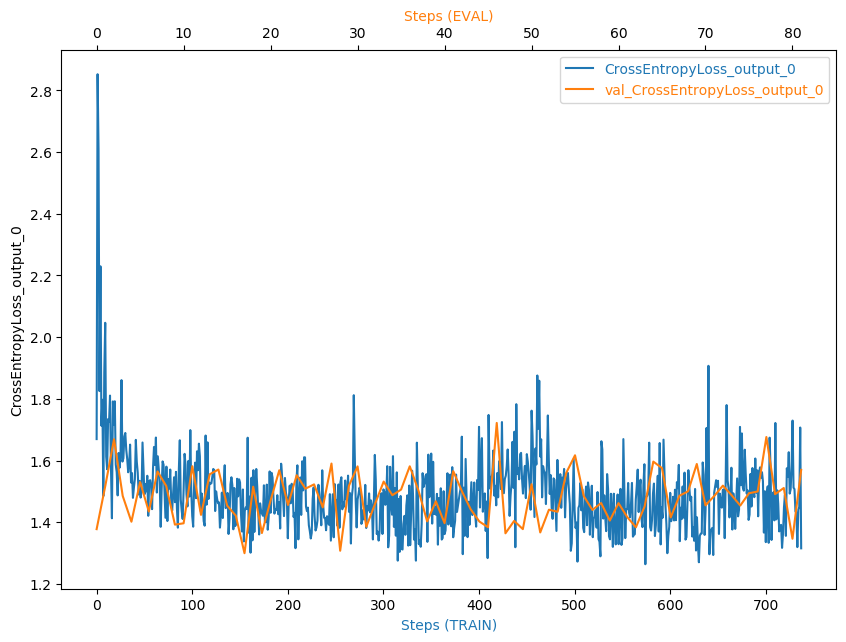

In [60]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

### Display the profiler output

In [71]:
 rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"profiler report is located at {rule_output_path}")

profiler report is located at s3://sagemaker-eu-west-2-237497095970/pytorch-train-with-debugger-2023-01-28-00-15-08-802/rule-output


In [69]:
#! aws s3 ls {rule_output_path} --recursive

In [70]:
#! aws s3 cp {rule_output_path} ./ --recursive

In [67]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [68]:
import IPython

# output the profiler report
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying


In [108]:
model_location=estimator.model_data

In [109]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [110]:
#Deploy your model to an endpoint
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [111]:
# Run an prediction on the endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

In [105]:
import requests 

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/767.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

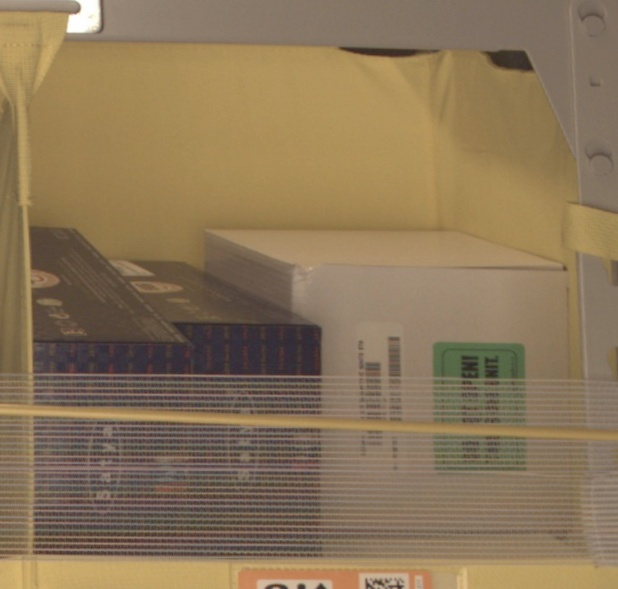

In [106]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [113]:
import json
response=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [114]:
response[0]

[-2.0685417652130127,
 -0.05794139206409454,
 0.17876869440078735,
 0.25809329748153687,
 -0.023833414539694786]

In [117]:
import numpy as np
np.argmax(response, 1)

array([3])

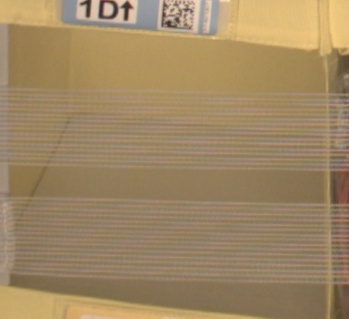

In [121]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/155.jpg" }

img_bytes = requests.get(request_dict['url']).content

Image.open(io.BytesIO(img_bytes))

In [122]:
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [139]:
response2[0]

[0.4270549714565277,
 0.17849138379096985,
 -0.39292657375335693,
 -0.7236183285713196,
 -1.1333048343658447]

In [123]:
np.argmax(response2, 1)

array([0])

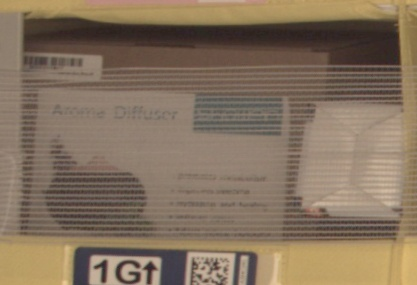

In [136]:
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/590.jpg" }

img_bytes = requests.get(request_dict['url']).content

Image.open(io.BytesIO(img_bytes))

In [137]:
response3=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [140]:
response3[0]

[-1.894127607345581,
 -0.12563461065292358,
 0.22617845237255096,
 0.3510580062866211,
 0.28727301955223083]

In [138]:
np.argmax(response3, 1)

array([3])

## Both response1,2,3 are predicted correctly!